In [1]:
import sys
sys.path.append('/home/ivan/distribution_connector')
import os

from sklearn.decomposition import TruncatedSVD


In [2]:
from sklearn import datasets
import numpy as np
import torch
from tqdm import tqdm
from connector_utils import test_models, gather_statistics, test_func
import matplotlib.pyplot as plt

In [3]:
from connector import Connector
# from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model
from tqdm import tqdm

In [4]:
import models
model_name = 'LinearOneLayer'
architecture = getattr(models, 'LinearOneLayerCF') #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    1024,
    1,
    "VGG",
    True,
    train_random=True,
    shuffle_train=False)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/'+model_name+'/curve3/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/'+model_name+'/curve4/checkpoint-400.pt')['model_state'])


Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
model1.cuda()
model2.cuda()
stat = {'train': [], 'test': []}
for i in tqdm(range(3, 11)):
    model1.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
    res = test_model(model1, loaders, cuda=True)
    stat['train'].append(res[0]['accuracy'])
    stat['test'].append(res[1]['accuracy'])


 12%|█▎        | 1/8 [00:13<01:37, 13.92s/it]

train results {'nll': 0.84960984167099, 'loss': 0.84960984167099, 'accuracy': 70.426}
test results {'nll': 1.3227679414749145, 'loss': 1.3227679414749145, 'accuracy': 59.11}


 25%|██▌       | 2/8 [00:27<01:23, 13.94s/it]

train results {'nll': 0.8486003172302246, 'loss': 0.8486003172302246, 'accuracy': 70.568}
test results {'nll': 1.3180574544906616, 'loss': 1.3180574544906616, 'accuracy': 59.4}


 38%|███▊      | 3/8 [00:41<01:09, 13.96s/it]

train results {'nll': 0.8484096311187744, 'loss': 0.8484096311187744, 'accuracy': 70.614}
test results {'nll': 1.3117229124069214, 'loss': 1.3117229124069214, 'accuracy': 59.09}


 50%|█████     | 4/8 [00:56<00:56, 14.01s/it]

train results {'nll': 0.8453139010810852, 'loss': 0.8453139010810852, 'accuracy': 70.672}
test results {'nll': 1.309335548019409, 'loss': 1.309335548019409, 'accuracy': 59.51}


 62%|██████▎   | 5/8 [01:10<00:42, 14.02s/it]

train results {'nll': 0.8470388956642151, 'loss': 0.8470388956642151, 'accuracy': 70.722}
test results {'nll': 1.3155865692138673, 'loss': 1.3155865692138673, 'accuracy': 58.91}


 75%|███████▌  | 6/8 [01:24<00:28, 14.28s/it]

train results {'nll': 0.852236960029602, 'loss': 0.852236960029602, 'accuracy': 70.422}
test results {'nll': 1.3110736963272094, 'loss': 1.3110736963272094, 'accuracy': 59.03}


 88%|████████▊ | 7/8 [01:41<00:14, 14.89s/it]

train results {'nll': 0.8487677566146851, 'loss': 0.8487677566146851, 'accuracy': 70.542}
test results {'nll': 1.313787916946411, 'loss': 1.313787916946411, 'accuracy': 58.95}


100%|██████████| 8/8 [01:58<00:00, 15.55s/it]

train results {'nll': 0.8487152013778686, 'loss': 0.8487152013778686, 'accuracy': 70.574}
test results {'nll': 1.3165094848632812, 'loss': 1.3165094848632812, 'accuracy': 59.01}


In [6]:
np.array(stat['train']).std(), np.array(stat['test']).std()

(0.09927109347639813, 0.20136642595030527)

In [7]:
np.array(stat['train']).mean(), np.array(stat['test']).mean()

(70.5675, 59.12625)

In [8]:
# model1.cuda();
# model1.eval();
# test_model(model1, loaders, cuda=True)

In [9]:
# model2.cuda();
# model2.eval();
# test_model(model2, loaders, cuda=True)

In [10]:
def get_data(data_type='train'):
    targ = []
    data = []
    for X, y in loaders[data_type]:
        data.append(X.view(-1,3*32*32).cpu().data.numpy())
        targ.append(y)

    data = np.concatenate(data)
    targ = np.concatenate(targ)
    
    return data, targ

In [11]:
data, targ = get_data(data_type='train')

In [12]:
data.shape, targ.shape

((50000, 3072), (50000,))

In [13]:
data_test, targ_test = get_data(data_type='test')

In [14]:
def next_layer(W, b, data):
    funcs = np.maximum(data @ W.T + b, 0)
    return funcs

    
def accuracy(pred, targ):
    ens_acc = 100.0 * np.mean(np.argmax(pred, axis=1) == targ)
    return ens_acc

def get_pred(W1, b1, W0, b0, data):
    pred =  np.maximum( data @ W0.T + b0, 0) @ W1.T  + b1
    return pred

In [15]:
class PointFinderInverse2():
    def __init__(self, model1, model2):
        out = {}
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.b10 = list(model1.parameters())[1].data.cpu().numpy()
        self.b20 = list(model2.parameters())[1].data.cpu().numpy()

        self.W11 = list(model1.parameters())[2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[2].data.cpu().numpy()

        self.b11 = list(model1.parameters())[3].data.cpu().numpy()
        self.b21 = list(model2.parameters())[3].data.cpu().numpy()

        self.funcs11 = next_layer(self.W10, self.b10, data=data) 
        self.funcs21 = next_layer(self.W20, self.b20, data=data)
        
        self.f_inv21 = np.linalg.pinv(self.funcs21.T)
        self.W11b2 = self.W11 @ self.funcs11.T @ self.f_inv21
        
        self.W10b = np.concatenate([self.W10, np.expand_dims(self.b10, axis=1)], axis=1)
        self.W20b = np.concatenate([self.W20, np.expand_dims(self.b20, axis=1)], axis=1)
        
    def find_point(self, t=0.5, method='arc_connect'):

        out = {}
        if 0<=t<=1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            Wn0 = getattr(Connector(self.W10b, self.W20b), method)(t=s)[1]
            Wn0 = Wn0[:, :-1]
            bn0 = Wn0[:, -1]
            
            funcs = next_layer(Wn0, bn0, data=data)
            f_inv = np.linalg.pinv(funcs.T)
            Wn1 = self.W11 @ self.funcs11.T @ f_inv
            
            pred = get_pred(Wn1, self.b11, Wn0, bn0, data) 
            out['train'] = accuracy(pred, targ)

            pred_test = get_pred(Wn1, self.b11, Wn0, bn0, data_test)
            out['test'] = accuracy(pred_test, targ_test)
            
        elif 1<t<=2:
            s = t - 1
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]
            bn1 = getattr(Connector(self.b11, self.b21), method)(t=s)[1]
            
            pred = get_pred(Wn1, bn1, self.W20, self.b20, data) 
            out['train'] = accuracy(pred, targ)

            pred_test = pred = get_pred(Wn1, bn1, self.W20, self.b20, data_test) 
            out['test'] = accuracy(pred_test, targ_test)
            
        else:
            assert not  0<=t<=2, 't is not in [0, 2]'
            
        print(t, out)

        return out

# Path Visualization 

In [16]:
# finder = PointFinderInverse(model1, model2) 
finder = PointFinderInverse2(model1, model2)

In [17]:
time = np.linspace(0, 2, 9)

In [18]:
time

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

In [19]:
path = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='arc_connect')
    path['test'].append(100-point['test']) 
    path['train'].append(100-point['train']) 

 11%|█         | 1/9 [00:32<04:21, 32.66s/it]

0.0 {'train': 70.212, 'test': 57.769999999999996}


 22%|██▏       | 2/9 [01:02<03:43, 31.88s/it]

0.25 {'train': 66.78, 'test': 56.93}


 33%|███▎      | 3/9 [01:32<03:07, 31.25s/it]

0.5 {'train': 62.572, 'test': 55.75}


 44%|████▍     | 4/9 [02:02<02:34, 31.00s/it]

0.75 {'train': 65.8, 'test': 57.489999999999995}


 56%|█████▌    | 5/9 [02:16<01:43, 25.85s/it]

1.0 {'train': 68.856, 'test': 58.43000000000001}


 67%|██████▋   | 6/9 [02:18<00:55, 18.57s/it]

1.25 {'train': 69.542, 'test': 59.75}


 78%|███████▊  | 7/9 [02:19<00:26, 13.48s/it]

1.5 {'train': 69.604, 'test': 59.63}


 89%|████████▉ | 8/9 [02:21<00:09,  9.92s/it]

1.75 {'train': 70.182, 'test': 59.660000000000004}


100%|██████████| 9/9 [02:23<00:00,  7.42s/it]

2.0 {'train': 70.784, 'test': 59.4}


In [20]:
100 - np.array(path['train'])

array([70.212, 66.78 , 62.572, 65.8  , 68.856, 69.542, 69.604, 70.182,
       70.784])

In [21]:
100 - np.array(path['test'])

array([57.77, 56.93, 55.75, 57.49, 58.43, 59.75, 59.63, 59.66, 59.4 ])

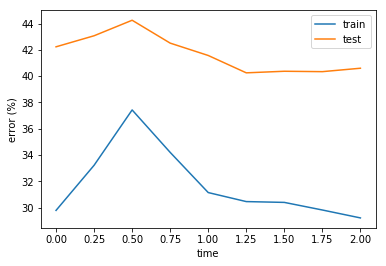

In [22]:
plt.plot(time, path['train'], label='train')
plt.plot(time, path['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [ ]:
path_l = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='lin_connect')
    path_l['test'].append(100-point['test']) 
    path_l['train'].append(100-point['train']) 

In [ ]:
plt.plot(time, path_l['train'], label='train')
plt.plot(time, path_l['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

# Count statistic in the fixed point

In [23]:
def get_stat(pointfinder, t=.5, method='arc_connect'):
    stat = {'test': [], 'train': []}
    for i in tqdm(range(3, 11)):
        model1.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
        model2.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])
        finder = pointfinder(model1, model2) 
        point = finder.find_point(t=t, method=method)
        stat['test'].append(point['test']) 
        stat['train'].append(point['train']) 
    return stat

In [24]:
def get_mean_svd(stat):
    train = np.array(stat['train'])
    test = np.array(stat['test'])
    return train.mean(), train.std(), test.mean(), test.std()

In [25]:
linpseudo = get_stat(PointFinderInverse2, t=.5, method='lin_connect')

 12%|█▎        | 1/8 [00:26<03:06, 26.62s/it]

0.5 {'train': 60.096000000000004, 'test': 53.190000000000005}


 25%|██▌       | 2/8 [00:53<02:39, 26.63s/it]

0.5 {'train': 60.694, 'test': 54.50000000000001}


 38%|███▊      | 3/8 [01:37<02:39, 31.93s/it]

0.5 {'train': 60.46, 'test': 53.33}


 50%|█████     | 4/8 [02:34<02:37, 39.47s/it]

0.5 {'train': 60.116, 'test': 53.2}


 62%|██████▎   | 5/8 [03:20<02:04, 41.54s/it]

0.5 {'train': 60.492000000000004, 'test': 53.65}


 75%|███████▌  | 6/8 [04:17<01:32, 46.16s/it]

0.5 {'train': 59.95, 'test': 52.64}


 88%|████████▊ | 7/8 [05:19<00:50, 50.78s/it]

0.5 {'train': 59.964, 'test': 53.349999999999994}


100%|██████████| 8/8 [06:08<00:00, 50.26s/it]

0.5 {'train': 60.106, 'test': 53.620000000000005}


In [26]:
linpseudo

{'test': [53.190000000000005,
  54.50000000000001,
  53.33,
  53.2,
  53.65,
  52.64,
  53.349999999999994,
  53.620000000000005],
 'train': [60.096000000000004,
  60.694,
  60.46,
  60.116,
  60.492000000000004,
  59.95,
  59.964,
  60.106]}

In [27]:
get_mean_svd(linpseudo)

(60.23475, 0.25791071614029604, 53.435, 0.49751884386423156)

In [28]:
arcpseudo = get_stat(PointFinderInverse2, t=.5, method='arc_connect')

 12%|█▎        | 1/8 [00:55<06:27, 55.31s/it]

0.5 {'train': 62.316, 'test': 55.31}


 25%|██▌       | 2/8 [01:55<05:40, 56.67s/it]

0.5 {'train': 63.104000000000006, 'test': 56.56}


 38%|███▊      | 3/8 [02:56<04:49, 57.94s/it]

0.5 {'train': 63.052, 'test': 55.57}


 50%|█████     | 4/8 [04:22<04:25, 66.38s/it]

0.5 {'train': 62.562, 'test': 55.04}


 62%|██████▎   | 5/8 [05:57<03:45, 75.01s/it]

0.5 {'train': 62.842, 'test': 55.76}


 75%|███████▌  | 6/8 [07:27<02:39, 79.58s/it]

0.5 {'train': 62.624, 'test': 55.53}


 88%|████████▊ | 7/8 [09:04<01:24, 84.80s/it]

0.5 {'train': 62.588, 'test': 55.589999999999996}


100%|██████████| 8/8 [10:27<00:00, 84.25s/it]

0.5 {'train': 62.666, 'test': 55.52}


In [29]:
arcpseudo

{'test': [55.31, 56.56, 55.57, 55.04, 55.76, 55.53, 55.589999999999996, 55.52],
 'train': [62.316,
  63.104000000000006,
  63.052,
  62.562,
  62.842,
  62.624,
  62.588,
  62.666]}

In [30]:
get_mean_svd(arcpseudo)

(62.71925, 0.24756198718704844, 55.61, 0.41176449579826613)